# Agent with RAG

https://python.langchain.com/docs/tutorials/qa_chat_history/

## Setup

### Packages

In [10]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph beautifulsoup4 langchain[google-genai] langchain-google-vertexai langchain-google-genai langchain-core

Note: you may need to restart the kernel to use updated packages.


### Environment variables

In [3]:
import getpass
import os

os.environ['LANGSMITH_TRACING'] = "true"
os.environ['LANGSMITH_API_KEY'] = getpass.getpass()

 ········


In [4]:
os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

Enter API key for Google Gemini:  ········


### Chat model

In [48]:
from langchain.chat_models import init_chat_model

chat_model = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

### Embedding model

In [49]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

### Vector store

In [178]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_core.documents import Document

vector_store: List[Document] = InMemoryVectorStore(embeddings)

## Chains

### Indexing

#### Load and split

In [179]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader

from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

INDEX_URL = "https://lilianweng.github.io/posts/2023-06-23-agent/"

# Load
loader = WebBaseLoader(
    web_paths=(INDEX_URL,),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [180]:
# Index
_ = vector_store.add_documents(documents=all_splits)

### Tie retrieve and generate tasks in a graph

In [181]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

### Retrieval step as tool

In [182]:
from langchain_core.tools import tool
from typing import Tuple

@tool(response_format="content_and_artifact")
def retrieve(query: str) -> Tuple[Tuple[str], list[Document]]:
    """Retrieve information related to user query"""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    print(f"Serialized: {serialized}")
    return serialized, retrieved_docs

In [183]:
from langchain_core.messages import SystemMessage
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.runnables.base import Runnable
from langchain_core.language_models.chat_models import BaseChatModel, LanguageModelInput
from langchain_core.messages.base import BaseMessage, BaseMessageChunk
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import ToolNode
from typing import Callable

LLM = chat_model
RETRIEVE_TOOL = retrieve

# Step 1: Generate an AIMessage that may include tool-call to be sent
def query_or_respond(state: MessagesState) -> Runnable[LanguageModelInput, BaseMessage]:
    """Generate tool call for retrieval or respond"""
    llm_with_tools = LLM.bind_tools([RETRIEVE_TOOL])
    response: Runnable[LanguageModelInput, BaseMessage] = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}

In [184]:
# Step 2: Tool as node
tools = ToolNode([retrieve])

In [185]:
# Step 3: Generate a response using the retrieved content
def generate(state: MessagesState):
    """ Generate answer """
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        print(f"State: {message}")
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system") or (message.type == "ai" and not message.tool_calls)
    ]

    prompt = [SystemMessage(system_message_content)] + conversation_messages
    
    # Run
    ai_message = LLM.invoke(prompt)
    return {"messages": [ai_message]}

In [186]:
# Compile it
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

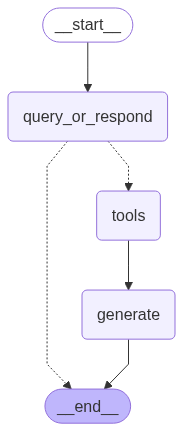

In [187]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Testing the app

In [188]:
from typing import Iterator

input_message = "Hello"

stream: Iterator[BaseMessageChunk] = graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values"
)

for step in stream:
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hi there! How can I help you today?


In [189]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (b1be361f-3a2f-45ab-be3e-41435e9cfbe9)
 Call ID: b1be361f-3a2f-45ab-be3e-41435e9cfbe9
  Args:
    query: What is Task Decomposition?
Serialized: Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.
Tree of T

## Stateful agent

### Memory store

In [192]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify threadid
config = {"configurable": {"thread_id": "abc123"}}

In [193]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (613e762d-04ec-4aba-a3f4-0a37fddd2c2e)
 Call ID: 613e762d-04ec-4aba-a3f4-0a37fddd2c2e
  Args:
    query: Task Decomposition
Serialized: Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.
Tree of Thoughts (

In [194]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (b8b41576-35ee-4968-85a1-1ba4fec55403)
 Call ID: b8b41576-35ee-4968-85a1-1ba4fec55403
  Args:
    query: common ways to do task decomposition
Serialized: Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s 

## Agents

In [199]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(LLM, [retrieve], checkpointer=memory)

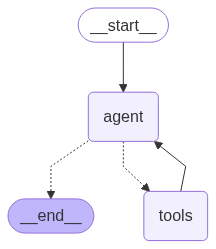

In [200]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [201]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (ef4deab7-a7cd-4776-96b5-850b2d1030c5)
 Call ID: ef4deab7-a7cd-4776-96b5-850b2d1030c5
  Args:
    query: standard method for Task Decomposition
Serialized: Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into mult